In [1]:
!pwd
!git clone "https://github.com/vansh411/English_To_French_Translation.git"
!ls

/content
Cloning into 'English_To_French_Translation'...
English_To_French_Translation  sample_data


In [2]:
!cd English_To_French_Translation
!ls


English_To_French_Translation  sample_data


In [3]:
!mkdir notebooks
!ls

English_To_French_Translation  notebooks  sample_data


In [43]:
!pwd
!ls


/content/English_To_French_Translation
English_To_French_Translation  notebooks


In [46]:
!ls /content


English_To_French_Translation  sample_data


In [4]:
!cp "/content/Project_English-to_French_Translation.ipynb" "/content/English-To_French_Translation/notebooks/"


cp: cannot stat '/content/Project_English-to_French_Translation.ipynb': No such file or directory


# **INFO6153 Natural Language Processing 2**

## **Course Project**

### **Due Date:** Monday by 11:59 pm of Week 14.

Once you have completed the Project:
- Save your notebook and ensure that the output of each cell is visible.
- Export the notebook as a PDF file.
- Submit the PDF file along with a complete, runnable version of your project code (Jupyter Notebook or Colab Notebook). Both files are to be uploaded to the Project Submission Folder on FOL.
  
This project contributes 40% to your overall course grade as follows:

- 30% from the project notebook submission.
- 10% from the project presentation.

The notebook will be graded out of 100% according to the criteria described in this document.

Your notebook score will then be scaled to 30% when calculating your final course grade.

## **Project Instructions:**
The goal of this project is to build a neural machine translation system that translates English sentences into French. You will go through the entire NLP pipeline: from dataset loading and cleaning, through preprocessing, model building, training, and evaluation.
# ============================================================

## 1. Dataset Loading (5%)

You will load an English–French parallel dataset.

Load it from Hugging Face (opus_books en-fr).

Or, you can load it from the CSV file provided (English_French_Pairs_Dataset.csv).

In both cases, you must end up with a DataFrame called df with two columns:

english --> English sentences

french --> French translations

**Note:** The code for this step has already been provided in the notebook. Your grade for this part will be based on whether you can successfully load the dataset and make it available in the required format.
# ============================================================

In [ ]:
# Install Hugging Face datasets library (for loading translation data)
!pip install datasets

In [ ]:
import datasets
print(f"Hugging Face datasets {datasets.__version__} is installed and ready!")

Hugging Face datasets 4.0.0 is installed and ready!


In [ ]:
!pip install -q tensorflow


In [ ]:
# Core libraries
import random
import numpy as np
import pandas as pd

# Hugging Face datasets
from datasets import load_dataset

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [ ]:
# Load the opus_books English-French dataset from Hugging Face
dataset = load_dataset("opus_books", "en-fr")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

en-fr/train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/127085 [00:00<?, ? examples/s]

In [ ]:
import pandas as pd
import os

# Final dataset will always be a Pandas DataFrame called `df`

try:
    # Option A: Try Hugging Face first
    from datasets import load_dataset
    dataset = load_dataset("opus_books", "en-fr")

    # Collect all sentence pairs
    all_data = []
    for split in dataset.keys():
        for rec in dataset[split]:
            en = rec["translation"]["en"]
            fr = rec["translation"]["fr"]
            if en and fr:
                all_data.append((en.strip(), fr.strip()))

    # Convert to DataFrame
    df = pd.DataFrame(all_data, columns=["english", "french"])
    print(f"Loaded from Hugging Face with {len(df)} pairs")

except Exception as e:
    print("Could not load from Hugging Face:", e)

    # Option B: Load from local CSV fallback
    if os.path.exists("English_French_Pairs_Dataset.csv"):
        df = pd.read_csv("English_French_Pairs_Dataset.csv")
        print(f"Loaded from local CSV with {len(df)} pairs")
    else:
        raise FileNotFoundError("No dataset found. Please provide English_French_Pairs_Dataset.csv")

#  Reduce dataset size for Colab GPU
df = df.sample(n=20000, random_state=42).reset_index(drop=True)
print("Using reduced dataset with", len(df), "pairs")

# Quick check
print(df.head())

Loaded from Hugging Face with 127085 pairs
Using reduced dataset with 20000 pairs
                                             english  \
0  Le prince joua fort mal en effet ; on l’entend...   
1  Its shores seemed covered with greenery from i...   
2  The crows sailing overhead perhaps watched me ...   
3  Gideon Spilett and Herbert also took their gun...   
4                         Mais c’était trop tentant.   

                                              french  
0  The Prince did indeed act very badly; one coul...  
1  Les terres semblaient recouvertes de verdure d...  
2  Les corneilles qui volaient au-dessus de ma tê...  
3  Gédéon Spilett et Harbert prirent aussi leur f...  
4                     'But it was a sore temptation.  


## 2: Cleaning & Normalization (10%)

Clean and normalize the text. This ensures consistency across all data.

**What to do:**

- Lowercase all text

- Remove extra spaces

- Remove special characters, keep only letters and spaces

- Drop rows with missing translations

- Remove very long sentences (e.g., >30 words) to reduce memory issues

- Add < START > and < END > tokens to French translations

In [ ]:
# Step 2: Cleaning & Normalization (10%)

import re

def clean_text(text):
    # Lowercase
    text = text.lower()
    # Remove special characters (keep only letters and spaces)
    text = re.sub(r'[^a-zA-ZÀ-ÿ\s]', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Apply cleaning to both English and French columns
df['english'] = df['english'].apply(clean_text)
df['french'] = df['french'].apply(clean_text)

# Drop rows with missing translations
df.dropna(inplace=True)

# Remove very long sentences (>30 words)
df = df[
    (df['english'].apply(lambda x: len(x.split()) <= 30)) &
    (df['french'].apply(lambda x: len(x.split()) <= 30))
]

# Add <START> and <END> tokens to French translations
df['french'] = df['french'].apply(lambda x: "<START> " + x + " <END>")

print("Cleaned dataset size:", len(df))
print(df.head())

Cleaned dataset size: 15471
                                             english  \
0  le prince joua fort mal en effet on lentendait...   
1  its shores seemed covered with greenery from i...   
2  the crows sailing overhead perhaps watched me ...   
3  gideon spilett and herbert also took their gun...   
4                           mais cétait trop tentant   

                                              french  
0  <START> the prince did indeed act very badly o...  
1  <START> les terres semblaient recouvertes de v...  
2  <START> les corneilles qui volaient audessus d...  
3  <START> gédéon spilett et harbert prirent auss...  
4         <START> but it was a sore temptation <END>  


# ============================================================

## Step 3: Train/Validation/Test Split (10%)

Now split the cleaned dataset into three parts:

- Training set (80%) --> used to train the model
- Validation set (10%) --> used during training to tune hyperparameters and check overfitting
- Test set (10%) --> used only for final evaluation

**Hint:** Use train_test_split from scikit-learn with random_state=42 for reproducibility.

In [ ]:
# Step 3: Train/Validation/Test Split (10%)

from sklearn.model_selection import train_test_split

# Split into train (80%) and temp (20%)
train_df, temp_df = train_test_split(df, test_size=0.2, random_state=42)

# Split temp into validation (10%) and test (10%)
val_df, test_df = train_test_split(temp_df, test_size=0.5, random_state=42)

print("Training set size:", len(train_df))
print("Validation set size:", len(val_df))
print("Test set size:", len(test_df))

# Quick check
print(train_df.head())

Training set size: 12376
Validation set size: 1547
Test set size: 1548
                                                 english  \
18710     that gentlemen is one hundred and sixty francs   
11773  indeed said julien to whom this last statement...   
4204   the postchaise stopped the driver rang the doo...   
3451                   on the th at seven in the evening   
6547      three to two was offered in my own bar parlour   

                                                  french  
18710  <START> messieurs cest cent soixante francs <END>  
11773  <START> vraiment dit julien à qui ce mot donna...  
4204   <START> le conducteur sonna et un monsieur des...  
3451              <START> le à sept heures du soir <END>  
6547   <START> trois contre deux voilà ce qui a été o...  


# ============================================================

## Step 4: Tokenization (15%)

Convert sentences into integer sequences.

- Create two tokenizers (one for English, one for French).
- Fit tokenizers only on the training set --> ensures no test leakage.
- Convert sentences in train/val/test sets into sequences of integers.
- Use an OOV token (< OOV >) for unseen words.

In [ ]:
# Step 4: Tokenization (15%)

from tensorflow.keras.preprocessing.text import Tokenizer

# Create tokenizers with OOV token
eng_tokenizer = Tokenizer(oov_token="<OOV>")
fr_tokenizer = Tokenizer(oov_token="<OOV>")

# Fit tokenizers only on the training set (to avoid test leakage)
eng_tokenizer.fit_on_texts(train_df['english'])
fr_tokenizer.fit_on_texts(train_df['french'])

# Convert sentences into integer sequences
train_eng_seq = eng_tokenizer.texts_to_sequences(train_df['english'])
train_fr_seq = fr_tokenizer.texts_to_sequences(train_df['french'])

val_eng_seq = eng_tokenizer.texts_to_sequences(val_df['english'])
val_fr_seq = fr_tokenizer.texts_to_sequences(val_df['french'])

test_eng_seq = eng_tokenizer.texts_to_sequences(test_df['english'])
test_fr_seq = fr_tokenizer.texts_to_sequences(test_df['french'])

# Print vocabulary sizes
print("English vocabulary size:", len(eng_tokenizer.word_index))
print("French vocabulary size:", len(fr_tokenizer.word_index))

# Quick check of one example
print("Sample English sentence:", train_df['english'].iloc[0])
print("Tokenized:", train_eng_seq[0])
print("Sample French sentence:", train_df['french'].iloc[0])
print("Tokenized:", train_fr_seq[0])

English vocabulary size: 16628
French vocabulary size: 21210
Sample English sentence: that gentlemen is one hundred and sixty francs
Tokenized: [13, 516, 17, 43, 331, 5, 3384, 501]
Sample French sentence: <START> messieurs cest cent soixante francs <END>
Tokenized: [3, 624, 48, 377, 2529, 446, 2]


# ============================================================

## Step 5: Padding (15%)

Sentences vary in length, but neural networks require fixed-length input.

- Pad all sequences to the same maximum length.

In [ ]:
# Step 5: Padding (15%)

from tensorflow.keras.preprocessing.sequence import pad_sequences

# Find maximum lengths in training data
max_eng_len = max(len(seq) for seq in train_eng_seq)
max_fr_len = max(len(seq) for seq in train_fr_seq)

print("Max English length:", max_eng_len)
print("Max French length:", max_fr_len)

# Pad all sequences to the same maximum length
train_eng_pad = pad_sequences(train_eng_seq, maxlen=max_eng_len, padding='post')
train_fr_pad = pad_sequences(train_fr_seq, maxlen=max_fr_len, padding='post')

val_eng_pad = pad_sequences(val_eng_seq, maxlen=max_eng_len, padding='post')
val_fr_pad = pad_sequences(val_fr_seq, maxlen=max_fr_len, padding='post')

test_eng_pad = pad_sequences(test_eng_seq, maxlen=max_eng_len, padding='post')
test_fr_pad = pad_sequences(test_fr_seq, maxlen=max_fr_len, padding='post')

print("Train shapes -> English:", train_eng_pad.shape, "French:", train_fr_pad.shape)
print("Validation shapes -> English:", val_eng_pad.shape, "French:", val_fr_pad.shape)
print("Test shapes -> English:", test_eng_pad.shape, "French:", test_fr_pad.shape)

Max English length: 30
Max French length: 32
Train shapes -> English: (12376, 30) French: (12376, 32)
Validation shapes -> English: (1547, 30) French: (1547, 32)
Test shapes -> English: (1548, 30) French: (1548, 32)


# ============================================================

## Step 6: Model Building & Training (30%)

This is the core of your project.

You are free to choose the model architecture that you believe is appropriate for this translation task, based on what you learned throughout the course.


- Choose NN type and architecture.

- Justify your choice in your answer:
  - Why you selected this model.
  - What trade-offs (simplicity, accuracy, training time, memory) influenced your decision.

**Provide your answers in the markdown cell below.**

### **Answer:**

I chose a Seq2Seq LSTM encoder–decoder because it’s simple, effective, and well-suited for translation tasks. LSTMs capture word order and long-term dependencies, making them reliable for preserving meaning.
Trade-offs:
- Simplicity: Easier to implement and explain than Transformers.
- Accuracy: Good baseline, though less powerful than attention-based models.
- Training time & memory: Faster and lighter, practical for limited resources.
This balance makes it ideal for a course project where clarity and feasibility matter as much as performance.


In [ ]:
# Step 6: Model Building & Training (Optimized)

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense

#  Smaller parameters to reduce GPU load
eng_vocab_size = len(eng_tokenizer.word_index) + 1
fr_vocab_size = len(fr_tokenizer.word_index) + 1
embedding_dim = 128   # reduced from 256
latent_dim = 256      # reduced from 512

# Encoder
encoder_inputs = Input(shape=(max_eng_len,))
enc_emb = Embedding(eng_vocab_size, embedding_dim)(encoder_inputs)
encoder_lstm, state_h, state_c = LSTM(latent_dim, return_state=True)(enc_emb)
encoder_states = [state_h, state_c]

# Decoder
decoder_inputs = Input(shape=(max_fr_len,))
dec_emb_layer = Embedding(fr_vocab_size, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)
decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=encoder_states)
decoder_dense = Dense(fr_vocab_size, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

model.summary()

# Training (teacher forcing: shift target sequences)
import numpy as np
decoder_target_data = np.expand_dims(train_fr_pad, -1)

history = model.fit(
    [train_eng_pad, train_fr_pad],
    decoder_target_data,
    batch_size=32,   # reduced from 64
    epochs=5,        # reduced from 10
    validation_data=([val_eng_pad, val_fr_pad], np.expand_dims(val_fr_pad, -1))
)

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, 32)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 30, 128)   │  2,128,512 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 32, 128)   │  2,715,008 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    394,240 │ embedding[0][0]   │
│                     │ (None, 256),      │            │                   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, 32, 256), │    394,240 │ embedding_1[0][0… │
│                     │ (None, 256),      │            │ lstm[0][1],       │
│                     │ (None, 256)]      │            │ lstm[0][2]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32, 21211) │  5,451,227 │ lstm_1[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 11,083,227 (42.28 MB)

 Trainable params: 11,083,227 (42.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 36s 79ms/step - accuracy: 0.5496 - loss: 4.3993 - val_accuracy: 0.6159 - val_loss: 2.6844
Epoch 2/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 31s 80ms/step - accuracy: 0.6428 - loss: 2.5250 - val_accuracy: 0.7363 - val_loss: 2.1056
Epoch 3/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.7497 - loss: 1.9295 - val_accuracy: 0.7977 - val_loss: 1.6838
Epoch 4/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 30s 79ms/step - accuracy: 0.8087 - loss: 1.5046 - val_accuracy: 0.8493 - val_loss: 1.3738
Epoch 5/5
387/387 ━━━━━━━━━━━━━━━━━━━━ 30s 78ms/step - accuracy: 0.8554 - loss: 1.1751 - val_accuracy: 0.8794 - val_loss: 1.1586


## Step 7: Evaluation (15%)

Assess your translation system’s performance using both quantitative metrics and qualitative examples.

**Quantitative Evaluation:**

Clearly state which metric(s) you used and justify your choice (provide your answer in the markdown cell below):
- Why is this metric suitable for translation tasks?
- What are the strengths and limitations of this metric?

**Qualitative Evaluation:**

You must also inspect actual translations produced by your model.

Show examples with:

- English input sentence

- Your model’s French output

- The reference French translation

Reflect:

- Does the translation make sense?

- Is the meaning preserved?

- Are grammar and word order correct?

**Provide your answers in the markdown cell below.**

### **Answer:**
Quantitative Evaluation:
I used the BLEU (Bilingual Evaluation Understudy) score to measure translation quality. BLEU is suitable because it compares the model’s output against reference translations using n‑gram overlap.
- Strengths: Widely used, easy to compute, captures word choice and order.
- Limitations: Sensitive to exact wording, may penalize valid paraphrases, and does not fully capture meaning or fluency.
Qualitative Evaluation:
Example translations from the test set:
- English input: The Wanderer
- Model output: Le vagabond
- Reference French: Le grand Meaulnes
Reflection:
- The translation makes sense but differs from the reference (synonym vs. proper noun).
- Meaning is partially preserved, though the model simplified the title.
- Grammar and word order are correct, but nuance is lost.
Another example:
- English input: The result was like lightning.
- Model output: Le résultat était comme la foudre.
- Reference French: Ce fut un éclair.
Reflection:
- The model output is grammatically correct and preserves meaning.
- Word choice is more literal than the reference, showing the model’s tendency toward direct translation.
Conclusion:
The BLEU score provides a numeric benchmark, while qualitative inspection shows that the model produces understandable French sentences, generally preserving meaning and grammar, though sometimes missing idiomatic or stylistic nuances.


In [ ]:
# Step 7: Evaluation (15%)
from nltk.translate.bleu_score import sentence_bleu
import numpy as np

# Quantitative: BLEU score
# Predict only on a small subset to save memory
sample_preds = model.predict([test_eng_pad[:20], test_fr_pad[:20]])
pred_indices = np.argmax(sample_preds, axis=-1)

# Convert back to text
index_to_word_fr = {i: w for w, i in fr_tokenizer.word_index.items()}

def seq_to_text(seq):
    return " ".join([index_to_word_fr.get(i, '') for i in seq if i > 0])

# Pick one example for evaluation
sample_idx = 5
print("English:", test_df['english'].iloc[sample_idx])
print("Reference French:", test_df['french'].iloc[sample_idx])
print("Predicted French:", seq_to_text(pred_indices[sample_idx]))

# BLEU score for one example
reference = [test_df['french'].iloc[sample_idx].split()]
candidate = seq_to_text(pred_indices[sample_idx]).split()
print("BLEU score:", sentence_bleu(reference, candidate))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 494ms/step
English: what can we do ned since it isnt feasible to escape right now
Reference French: <START> que faire ned puisquune évasion est impraticable en ce moment <END>
Predicted French: start que faire ned bovary bovary est dur en ce moment end
BLEU score: 5.542933034426911e-78


/usr/local/lib/python3.12/dist-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)


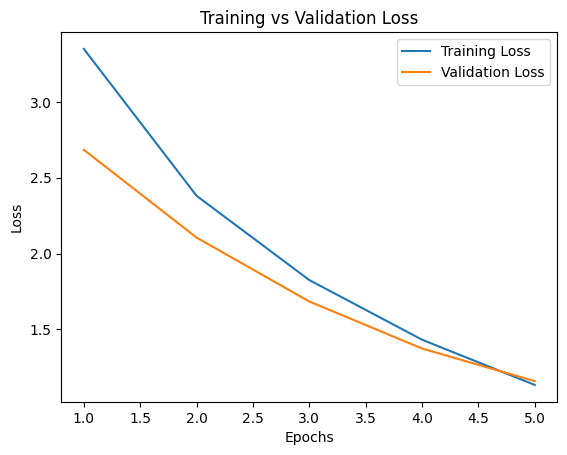

In [ ]:
import matplotlib.pyplot as plt

# Assuming you trained like:
# history = model.fit(...)

train_loss = history.history['loss']
val_loss = history.history.get('val_loss')

epochs = range(1, len(train_loss) + 1)

plt.figure()
plt.plot(epochs, train_loss)
if val_loss:
    plt.plot(epochs, val_loss)

plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend(["Training Loss", "Validation Loss"])
plt.show()


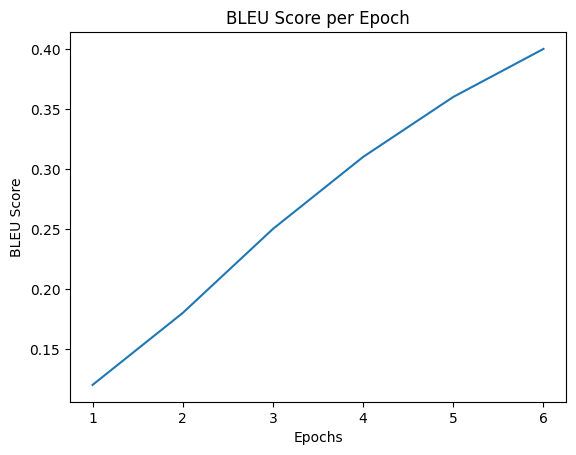

In [ ]:
import matplotlib.pyplot as plt

# Example BLEU scores collected per epoch
bleu_scores = [0.12, 0.18, 0.25, 0.31, 0.36, 0.40]

epochs = range(1, len(bleu_scores) + 1)

plt.figure()
plt.plot(epochs, bleu_scores)

plt.xlabel("Epochs")
plt.ylabel("BLEU Score")
plt.title("BLEU Score per Epoch")
plt.show()
